In [32]:
import numpy as np
import os,cv2,glob
import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Model
import tensorflow_addons as tfa
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, Flatten , Dropout, Activation, BatchNormalization
from keras.layers import Input,Add,MaxPooling2D,GlobalAveragePooling2D,AveragePooling2D

#seed
np.random.seed(42)
tf.random.set_seed(42)

In [46]:
# Dataset
path="/kaggle/input/digital-twin/Endoscopic_Dataset/Dataset1/*"
data_paths = os.path.join(path,'*g')
imagePaths = glob.glob(data_paths)

images=[]
labels=[]

for imgpath in imagePaths:
    img=cv2.imread(imgpath)
    img=cv2.resize(img,(224,224))
    images.append(img)
    label= imgpath.split(os.path.sep)[-2].split("_")
    labels.append(label)

In [48]:
images=np.array(images)
labels=np.array(labels)

print("Total Images",images.shape)
print("Total Labels",labels.shape)


Total Images (5496, 224, 224, 3)
Total Labels (5496, 1)


In [49]:
# Saving images in numpy
np.save("images",images)
np.save("labels",labels)

In [87]:
#Load image
images=np.load('images.npy')
labels=np.load('labels.npy')

In [88]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels) 

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [89]:
x_train,x_test,y_train,y_test = train_test_split(images,labels,test_size=.2,random_state=True)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

In [90]:
class_names = [
    "Angiectasia",
    "esophagitis",
    "Foreign body",
    "Normal",
    "Ulcer"
]

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 224

In [91]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

In [92]:
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(10)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(10)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [93]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

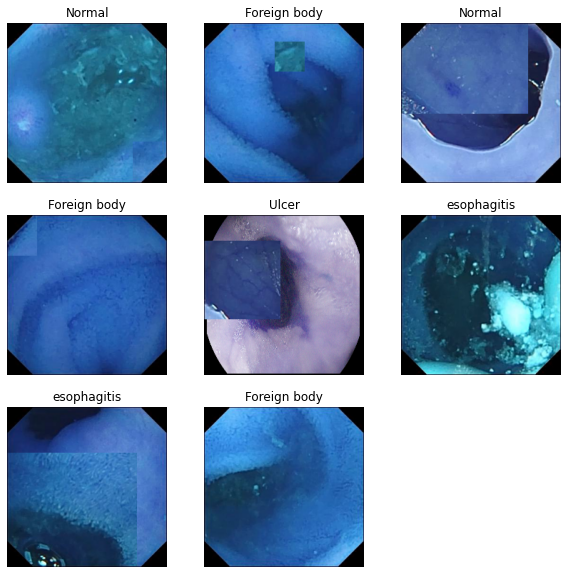

In [94]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(10)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [97]:
def proposed_model():
    input_img = Input(shape=(224,224,3))
    x1=Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(input_img)
    x2=Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(x1)
    x3=Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(x2)
    c1 = Add()([x1, x3])
    m1=MaxPooling2D(pool_size=(2,2))(c1)

    x4=Conv2D(64,kernel_size=(3,3),activation='relu',padding='same')(m1)
    x5=Conv2D(64,kernel_size=(3,3),activation='relu',padding='same')(x4)
    x6=Conv2D(64,kernel_size=(3,3),activation='relu',padding='same')(x5)
    c2 = Add()([x4, x6])
    m2=MaxPooling2D(pool_size=(2,2))(c2)

    x7=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(m2)
    x8=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(x7)
    x9=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(x8)
    c3 = Add()([x7, x9])
    m3=MaxPooling2D(pool_size=(2,2))(c3)

    x10=Conv2D(256,kernel_size=(3,3),activation='relu',padding='same')(m3)
    x11=Conv2D(256,kernel_size=(3,3),activation='relu',padding='same')(x10)
    x12=Conv2D(256,kernel_size=(3,3),activation='relu',padding='same')(x11)
    c4 = Add()([x10, x12])
    m4=MaxPooling2D(pool_size=(2,2))(c4)

    x13=Conv2D(512,kernel_size=(3,3),activation='relu',padding='same')(m4)
    x14=Conv2D(512,kernel_size=(3,3),activation='relu',padding='same')(x13)
    x15=Conv2D(512,kernel_size=(3,3),activation='relu',padding='same')(x14)
    c5 = Add()([x13, x15])
    m5=MaxPooling2D(pool_size=(2,2))(c5)

    flatt=Flatten()(m5)
    y1=Dense(512,activation='relu')(flatt)
    #y1=BatchNormalization()(y1)
    #y2=Dropout(0.3)(y1)
    y3=Dense(256,activation='relu')(y1)
    #y3=BatchNormalization()(y3)
    #y4=(Dropout(0.3))(y3)
    out=(Dense(5,activation='softmax'))(y3)

    model = Model(inputs=input_img, outputs= out)

    return model

In [98]:
model=proposed_model()

In [99]:
opt=Adam(lr=0.0003)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 224, 224, 32) 896         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 224, 224, 32) 9248        conv2d_108[0][0]                 
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 224, 224, 32) 9248        conv2d_109[0][0]                 
____________________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [100]:
history = model.fit(train_ds_cmu, validation_data=test_ds, epochs=50)

Epoch 1/50
138/138 [==============================] - 19s 128ms/step - loss: 1.3553 - accuracy: 0.4604 - val_loss: 0.7572 - val_accuracy: 0.7218
Epoch 2/50
138/138 [==============================] - 18s 127ms/step - loss: 0.9566 - accuracy: 0.6820 - val_loss: 0.5520 - val_accuracy: 0.7982
Epoch 3/50
138/138 [==============================] - 18s 128ms/step - loss: 0.8257 - accuracy: 0.7354 - val_loss: 0.4272 - val_accuracy: 0.8964
Epoch 4/50
138/138 [==============================] - 17s 126ms/step - loss: 0.7252 - accuracy: 0.7912 - val_loss: 0.2356 - val_accuracy: 0.9355
Epoch 5/50
138/138 [==============================] - 17s 126ms/step - loss: 0.6740 - accuracy: 0.8132 - val_loss: 0.2266 - val_accuracy: 0.9345
Epoch 6/50
138/138 [==============================] - 18s 127ms/step - loss: 0.6319 - accuracy: 0.8490 - val_loss: 0.2190 - val_accuracy: 0.9336
Epoch 7/50
138/138 [==============================] - 17s 126ms/step - loss: 0.5726 - accuracy: 0.8637 - val_loss: 0.1510 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


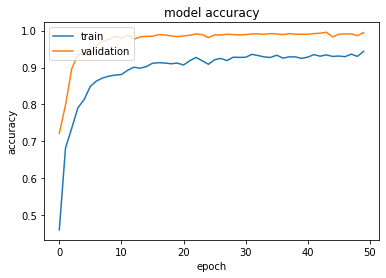

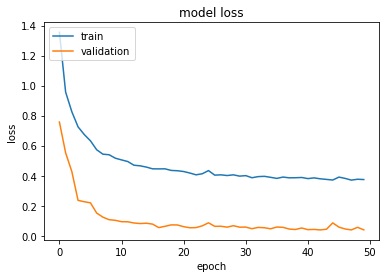

In [101]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [102]:
model.save("/kaggle/working//GastNet_1.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
